In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

import shap

Load sick and healthy patients

In [2]:
with open("data/eid_sick") as f:
    eid_sick = list(map(int, f.read().split('\n')))

with open("data/eid_healthy") as f:
    eid_healthy = list(map(int, f.read().split('\n')))

len(eid_sick), len(eid_healthy)

(26314, 476056)

Load column descriptions

In [3]:
column_desc = {}

with open("data/my_columns") as f:
    my_columns = f.read().split('\n')

with open("data/filtered_fields") as f:
    lines = f.read().split('\n')
    category = ''
    
    for line in lines:
        if line == '':
            continue
        
        # New category
        if line[0] == '#':
            category = line.split(' - ')[-1]
            column_desc[category] = {}
            
        # Fill category
        else:
            field, fdesc, ftype = line.split('\t')
            column_desc[category][f'{field}-0.0'] = (fdesc, ftype)
    
print(f'{len(column_desc)} categories, total of {sum([len(fields) for fields in column_desc.values()])} columns')
print('===================================')
for category, cols in column_desc.items():
    print(f'{category}: {len(cols)} columns')

11 categories, total of 193 columns
Physical activity: 24 columns
Sleep: 7 columns
Smoking: 26 columns
Diet: 28 columns
Alcohol: 19 columns
Chest pain: 4 columns
Blood pressure: 8 columns
Arterial stiffness: 8 columns
Body size measures: 8 columns
Blood count: 31 columns
Blood biochemistry: 30 columns


In [4]:
filtered_columns = [
    col
    for cols in column_desc.values()
    for col in cols
]

Read my data

In [5]:
df_sick = pd.read_csv('data/sick_data.csv', 
                      usecols=['eid'] + filtered_columns, 
                      index_col=['eid'])
df_healthy = pd.read_csv('data/my_data.csv', 
                         usecols=['eid'] + filtered_columns, 
                         index_col=['eid'],
                         nrows=2 * len(df_sick))
df_healthy = df_healthy.loc[list(set(eid_healthy) & set(df_healthy.index))[:len(df_sick)]]

len(df_sick), len(df_healthy)

(26314, 26314)

In [6]:
df_sick['diagnosis'] = 1
df_healthy['diagnosis'] = 0
df_raw = pd.concat([df_sick, df_healthy])

In [7]:
eid_train, eid_test = train_test_split(df_raw.index.to_list(), test_size=0.1, random_state=42)
eid_train, eid_val = train_test_split(eid_train, test_size=0.1, random_state=42)

len(eid_train), len(eid_val), len(eid_test)

(42628, 4737, 5263)

### Impute missing & negative values

In [9]:
column_missing_values = pd.Series()

for category, cols in column_desc.items():
    print()
    print(category)
    nulls = df_raw[cols.keys()].isna().sum(axis=0)
    negs = (np.logical_and(df_raw[cols.keys()] < 0, df_raw[cols.keys()] > -10)).sum(axis=0)
    print(negs + nulls)
    
    column_missing_values = pd.concat([column_missing_values, nulls + negs])


Physical activity
1100-0.0     1868
2634-0.0    32389
1021-0.0    28641
894-0.0     14801
3647-0.0    30357
1001-0.0    48309
914-0.0     25935
874-0.0      8400
981-0.0     17433
2624-0.0    32453
1011-0.0    28523
3637-0.0    30376
943-0.0      1247
991-0.0     48311
971-0.0     17427
884-0.0      3159
904-0.0      3253
864-0.0      1397
1090-0.0     1172
1080-0.0     1126
1070-0.0      628
6164-0.0     5093
6162-0.0     1071
924-0.0       658
dtype: int64

Sleep
1160-0.0     499
1170-0.0     677
1180-0.0    6445
1190-0.0     212
1200-0.0     185
1210-0.0    3897
1220-0.0     472
dtype: int64

Smoking
20160-0.0      376
20162-0.0    33819
20161-0.0    33819
20116-0.0      389
1239-0.0       163
1249-0.0      4969
2644-0.0     40178
3436-0.0     48079
3456-0.0     48410
3466-0.0     48451
3476-0.0     48436
3486-0.0     48057
3496-0.0     48160
3506-0.0     48050
6158-0.0     51109
2867-0.0     36981
2877-0.0     36927
2887-0.0     38009
2897-0.0     36998
2907-0.0     37278
6157-0.0

In [10]:
for missing_th in range(5000, 50001, 5000):
    print(f'taking only columns with less than {missing_th} missing values, we are left with {len(column_missing_values[column_missing_values < missing_th])} columns')

taking only columns with less than 5000 missing values, we are left with 107 columns
taking only columns with less than 10000 missing values, we are left with 125 columns
taking only columns with less than 15000 missing values, we are left with 129 columns
taking only columns with less than 20000 missing values, we are left with 136 columns
taking only columns with less than 25000 missing values, we are left with 137 columns
taking only columns with less than 30000 missing values, we are left with 141 columns
taking only columns with less than 35000 missing values, we are left with 156 columns
taking only columns with less than 40000 missing values, we are left with 164 columns
taking only columns with less than 45000 missing values, we are left with 168 columns
taking only columns with less than 50000 missing values, we are left with 190 columns


In [11]:
df_raw[df_raw == -10] = 0
df_raw[df_raw < 0] = np.nan

In [47]:
common_columns = column_missing_values[column_missing_values < len(df_raw) // 5].index.to_list() + ['diagnosis']

df_full = df_raw[common_columns].copy()

imputer = SimpleImputer(strategy='most_frequent').fit(df_full.loc[eid_train])

df_full.loc[eid_train] = imputer.transform(df_full.loc[eid_train])
df_full.loc[eid_val] = imputer.transform(df_full.loc[eid_val])

In [48]:
len(df_full.columns)

127

### Correlation

In [50]:
column_target_corr = abs(df_full.drop(columns=['diagnosis']).apply(lambda x: x.corr(df_full['diagnosis'])))
min(column_target_corr), max(column_target_corr)

(0.0016186505810193237, 0.2810050930726125)

In [51]:
curr_ths = np.linspace(0.002, 0.1, 5)
num_columns = [len(column_target_corr[column_target_corr > curr_th]) for curr_th in curr_ths]

print(curr_ths, num_columns)

[0.002  0.0265 0.051  0.0755 0.1   ] [125, 90, 66, 56, 42]


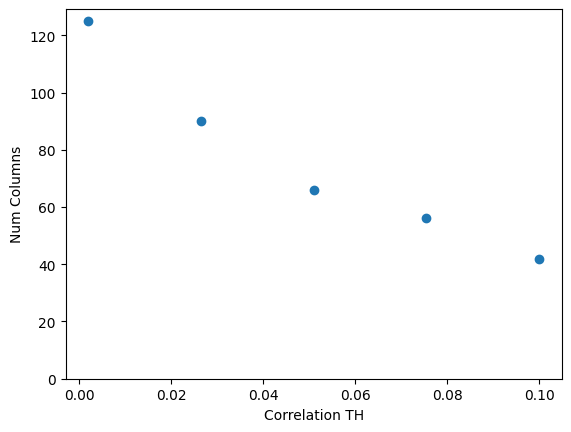

In [53]:
plt.scatter(curr_ths, num_columns)
plt.xlabel("Correlation TH")
plt.ylabel("Num Columns")
plt.yticks(np.arange(0,140,20))
plt.show()

In [54]:
def classify(df):

    X_train = df.loc[eid_train].drop(columns=['diagnosis'])
    y_train = df.loc[eid_train]['diagnosis']
    X_val = df.loc[eid_val].drop(columns=['diagnosis'])
    y_val = df.loc[eid_val]['diagnosis']

    classifiers = {
        "LOG-REG": LogisticRegression(solver='liblinear',max_iter=1000),
        "MLP": MLPClassifier(hidden_layer_sizes=[50, 50],max_iter=1000),
        "FOREST": RandomForestClassifier(max_depth=8, n_estimators=70),
        "ADA": AdaBoostClassifier(learning_rate=0.1,n_estimators=100),
        "XGB": XGBClassifier(eta=0.1,max_depth=8)
    }

    for name, clf in classifiers.items():
        print(f'{name}')
        clf.fit(X_train, y_train)
        print(F'\ttrain score: {100 * clf.score(X_train, y_train):.3f} f1: {f1_score(y_train, clf.predict(X_train)):.3f}, auc: {roc_auc_score(y_train, clf.predict(X_train)):.3f}') 
        print(f'\tval score: {100 * clf.score(X_val, y_val):.3f}, f1: {f1_score(y_val, clf.predict(X_val)):.3f}, auc: {roc_auc_score(y_val, clf.predict(X_val)):.3f}')

In [55]:
for curr_th, num_cols in zip(curr_ths, num_columns):
    print("===============")
    print(f"COLUMNS = {num_cols}")
    print("===============")
    
    classify(df_full[column_target_corr[column_target_corr > curr_th].index.to_list() + ['diagnosis']])

COLUMNS = 125
LOG-REG
	train score: 72.267 f1: 0.720, auc: 0.723
	val score: 73.190, f1: 0.730, auc: 0.732
MLP
	train score: 74.031 f1: 0.739, auc: 0.740
	val score: 72.746, f1: 0.726, auc: 0.727
FOREST
	train score: 74.543 f1: 0.748, auc: 0.745
	val score: 70.783, f1: 0.712, auc: 0.708
ADA
	train score: 71.233 f1: 0.709, auc: 0.712
	val score: 71.269, f1: 0.712, auc: 0.713
XGB
	train score: 90.365 f1: 0.903, auc: 0.904
	val score: 73.169, f1: 0.732, auc: 0.732
COLUMNS = 90
LOG-REG
	train score: 72.154 f1: 0.718, auc: 0.722
	val score: 72.620, f1: 0.725, auc: 0.726
MLP
	train score: 70.876 f1: 0.738, auc: 0.709
	val score: 71.163, f1: 0.742, auc: 0.711
FOREST
	train score: 74.634 f1: 0.747, auc: 0.746
	val score: 70.783, f1: 0.712, auc: 0.708
ADA
	train score: 71.233 f1: 0.709, auc: 0.712
	val score: 71.269, f1: 0.712, auc: 0.713
XGB
	train score: 89.397 f1: 0.893, auc: 0.894
	val score: 72.430, f1: 0.726, auc: 0.724
COLUMNS = 66
LOG-REG
	train score: 71.798 f1: 0.714, auc: 0.718
	val 

### SHAP

In [56]:
c_desc = {
    c: cdesc
    for cols in column_desc.values()
    for c, (cdesc, _) in cols.items()
}

In [ ]:
set(column_desc['Blood biochemistry'].keys()) & (df_full)

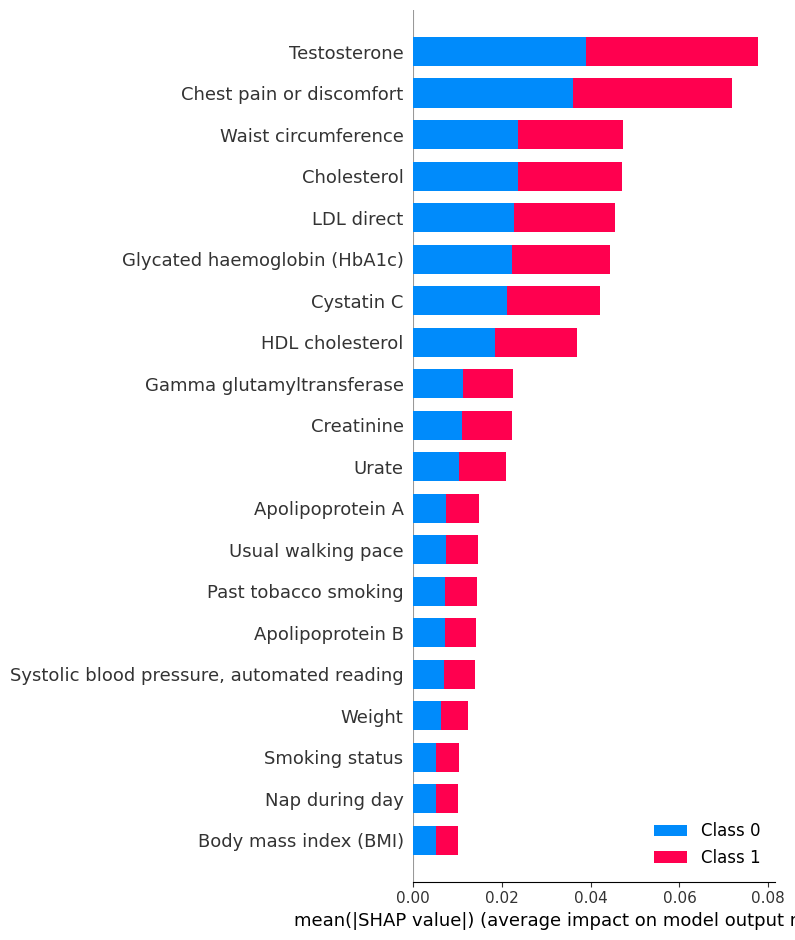

In [66]:
np.bool = np.bool_
feature_names = [c_desc[col] for col in df_full.columns[:-1]]

X_train = StandardScaler().fit_transform(df_full.loc[eid_train].drop(columns=['diagnosis']))

forest = RandomForestClassifier(max_depth=8, min_samples_split=9, n_estimators=70).fit(X_train, df_full.loc[eid_train]['diagnosis'])

explainer_forest = shap.TreeExplainer(forest)
shap_vals_forest = explainer_forest.shap_values(X_train)

shap.summary_plot(shap_vals_forest, feature_names=feature_names)

In [71]:
shap_columns = [
    '30850-0.0',
    '2335-0.0',
    '48-0.0',
    '30690-0.0',
    '30780-0.0',
    '30750-0.0',
    '30720-0.0',
    '30760-0.0',
    '30730-0.0',
    '30700-0.0',
    '30880-0.0',
    '30630-0.0',
    '924-0.0',
    '1249-0.0',
    '30640-0.0',
    '4080-0.0',
    '21002-0.0',
    '20116-0.0',
    '1190-0.0',
    '21001-0.0',
    'diagnosis'
]

df_shap = df_raw[shap_columns].dropna()

eid_train_shap = list(set(df_shap.index.to_list()) & set(eid_train))
eid_val_shap = list(set(df_shap.index.to_list()) & set(eid_val))

scaler = StandardScaler().fit(df_shap.loc[eid_train_shap].drop(columns=['diagnosis']), df_shap['diagnosis'])

X_train_shap = scaler.transform(df_shap.loc[eid_train_shap].drop(columns=['diagnosis']))
y_train_shap = df_full.loc[eid_train_shap]['diagnosis']
X_val_shap = scaler.transform(df_shap.loc[eid_val_shap].drop(columns=['diagnosis']))
y_val_shap = df_full.loc[eid_val_shap]['diagnosis']

In [75]:
names = [
    "KNN",
    "SVM",
    "LR",
    "MLP",
    "RF",
    "ADA",
    "XGBoost"
]

classifiers = [
    KNeighborsClassifier(20),
    SVC(kernel="rbf"),
    LogisticRegression(solver='liblinear',max_iter=10000),
    MLPClassifier(hidden_layer_sizes=[50],max_iter=1000),
    RandomForestClassifier(max_depth=8, n_estimators=70),
    AdaBoostClassifier(learning_rate=0.1,n_estimators=100),
    XGBClassifier(eta=0.1,max_depth=8)
    
]

for clf, name in zip(classifiers, names):
    print(f'{name}')

    clf.fit(X_train_shap, y_train_shap)
    
    print(F'\ttrain score: {100 * clf.score(X_train_shap, y_train_shap):.3f} f1: {f1_score(y_train_shap, clf.predict(X_train_shap)):.3f}, auc: {roc_auc_score(y_train_shap, clf.predict(X_train_shap)):.3f}') 
    print(f'\tval score: {100 * clf.score(X_val_shap, y_val_shap):.3f}, f1: {f1_score(y_val_shap, clf.predict(X_val_shap)):.3f}, auc: {roc_auc_score(y_val_shap, clf.predict(X_val_shap)):.3f}')

KNN
	train score: 73.260 f1: 0.723, auc: 0.733
	val score: 69.960, f1: 0.688, auc: 0.700
SVM
	train score: 74.732 f1: 0.750, auc: 0.747
	val score: 72.117, f1: 0.727, auc: 0.721
LR
	train score: 71.573 f1: 0.716, auc: 0.716
	val score: 71.106, f1: 0.714, auc: 0.711
MLP
	train score: 75.020 f1: 0.752, auc: 0.750
	val score: 71.544, f1: 0.718, auc: 0.715
RF
	train score: 75.454 f1: 0.755, auc: 0.755
	val score: 71.342, f1: 0.716, auc: 0.713
ADA
	train score: 71.912 f1: 0.719, auc: 0.719
	val score: 71.173, f1: 0.713, auc: 0.712
XGBoost
	train score: 87.036 f1: 0.870, auc: 0.870
	val score: 71.612, f1: 0.718, auc: 0.716
